In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
subfolders = [
    "/content/drive/MyDrive/Dataframes/Sample Testing Alzehimer Dataset/test/Mild Impairment",
    "/content/drive/MyDrive/Dataframes/Sample Testing Alzehimer Dataset/test/Moderate Impairment",
    "/content/drive/MyDrive/Dataframes/Sample Testing Alzehimer Dataset/test/No Impairment",
    "/content/drive/MyDrive/Dataframes/Sample Testing Alzehimer Dataset/test/Very Mild Impairment"
]

# Directorio para combinar las imágenes
combined_dir = "/content/combined_images"
os.makedirs(combined_dir, exist_ok=True)

# Copiar las imágenes a combined_dir
for subfolder in subfolders:
    for filename in os.listdir(subfolder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ajusta las extensiones
            source = os.path.join(subfolder, filename)
            destination = os.path.join(combined_dir, filename)
            shutil.copy2(source, destination)

# data_path ahora apunta al directorio combinado
data_path = combined_dir

print(f"Las imágenes se han combinado en: {data_path}")

Las imágenes se han combinado en: /content/combined_images


In [4]:
# Parámetros
img_size = 64
batch_size = 64
latent_dim = 100
lambda_gp = 10

In [5]:
# Función para cargar las imágenes
def load_images(path, img_size):
    images = []
    for file_name in os.listdir(path):
        img_path = os.path.join(path, file_name)
        img = load_img(img_path, target_size=(img_size, img_size))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

In [6]:
# Cargar el dataset
images = load_images(data_path, img_size)
print(f"Total de imágenes cargadas: {images.shape}")

Total de imágenes cargadas: (1122, 64, 64, 3)


In [7]:

# Crear dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [8]:
# Arquitectura del generador
def build_generator():
    model = keras.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=latent_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='sigmoid'),
    ])
    return model


In [9]:
# Arquitectura del crítico (discriminador)
def build_critic():
    model = keras.Sequential([
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(img_size, img_size, 3)),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [10]:
# Función para calcular el gradiente
def gradient_penalty(f, real, fake):
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0., 1.)
    interpolated = real * alpha + fake * (1 - alpha)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = f(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp


In [11]:
# Inicializar modelos
generator = build_generator()
critic = build_critic()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Optimizadores
g_opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
d_opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [13]:
# Función para guardar los modelos
def save_models(generator, critic, epoch, save_path="/content/models", drive_path="/content/drive/MyDrive/WGAN-GP-Alzheimer"):
    os.makedirs(save_path, exist_ok=True)
    os.makedirs(drive_path, exist_ok=True)

    generator.save(os.path.join(save_path, f"generator_epoch_{epoch}.h5"))
    critic.save(os.path.join(save_path, f"critic_epoch_{epoch}.h5"))


    generator.save(os.path.join(drive_path, f"generator_epoch_{epoch}.h5"))
    critic.save(os.path.join(drive_path, f"critic_epoch_{epoch}.h5"))
    print(f"Modelos guardados en: {save_path}")

In [14]:
# Entrenamiento
@tf.function
def train_step(real_images):
    d_loss_avg = 0
    for _ in range(5):
        noise = tf.random.normal([batch_size, latent_dim])
        with tf.GradientTape() as d_tape:
            fake_images = generator(noise, training=True)
            real_output = critic(real_images, training=True)
            fake_output = critic(fake_images, training=True)

            gp = gradient_penalty(critic, real_images, fake_images)
            d_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + lambda_gp * gp

        d_grad = d_tape.gradient(d_loss, critic.trainable_variables)
        d_opt.apply_gradients(zip(d_grad, critic.trainable_variables))

        d_loss_avg += d_loss / 5

    noise = tf.random.normal([batch_size, latent_dim])
    with tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)
        fake_output = critic(fake_images, training=True)
        g_loss = -tf.reduce_mean(fake_output)

    g_grad = g_tape.gradient(g_loss, generator.trainable_variables)
    g_opt.apply_gradients(zip(g_grad, generator.trainable_variables))

    return d_loss_avg, g_loss

In [15]:
# Función para generar imágenes de ejemplo
def generate_and_save_images(model, epoch, num_examples=16):
    noise = tf.random.normal([num_examples, latent_dim])
    images = model(noise, training=False)
    plt.figure(figsize=(4, 4))
    for i in range(num_examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
    plt.savefig(f"generated_image_epoch_{epoch}.png")
    plt.close()


Epoch 1/100 - D Loss: -4.8425, G Loss: -11.0406
Epoch 2/100 - D Loss: -4.7065, G Loss: -4.4586
Epoch 3/100 - D Loss: -4.6908, G Loss: -4.4586
Epoch 4/100 - D Loss: -4.8673, G Loss: -3.9507


Epoch 5/100 - D Loss: -4.7546, G Loss: -12.1689


Modelos guardados en: /content/models
Epoch 6/100 - D Loss: -4.6413, G Loss: -7.1722
Epoch 7/100 - D Loss: -4.6740, G Loss: -0.7109
Epoch 8/100 - D Loss: -4.7438, G Loss: -2.2882
Epoch 9/100 - D Loss: -4.3864, G Loss: -5.9437
Epoch 10/100 - D Loss: -4.7555, G Loss: -5.4271


Modelos guardados en: /content/models
Epoch 11/100 - D Loss: -4.7373, G Loss: -12.2076
Epoch 12/100 - D Loss: -4.5132, G Loss: -6.3263
Epoch 13/100 - D Loss: -4.0350, G Loss: -7.1702
Epoch 14/100 - D Loss: -4.6168, G Loss: -11.0421


Epoch 15/100 - D Loss: -4.4049, G Loss: -1.1859


Modelos guardados en: /content/models
Epoch 16/100 - D Loss: -4.4071, G Loss: -4.6157
Epoch 17/100 - D Loss: -4.7343, G Loss: -4.8707
Epoch 18/100 - D Loss: -4.5148, G Loss: -6.9170
Epoch 19/100 - D Loss: -4.7533, G Loss: -16.5586


Epoch 20/100 - D Loss: -4.2951, G Loss: -4.7846


Modelos guardados en: /content/models
Epoch 21/100 - D Loss: -4.6783, G Loss: -8.7859
Epoch 22/100 - D Loss: -4.3790, G Loss: -5.0833
Epoch 23/100 - D Loss: -4.3697, G Loss: -4.9093
Epoch 24/100 - D Loss: -4.4020, G Loss: -7.3159


Epoch 25/100 - D Loss: -4.8570, G Loss: -0.2003


Modelos guardados en: /content/models
Epoch 26/100 - D Loss: -4.7241, G Loss: 2.1488
Epoch 27/100 - D Loss: -3.9352, G Loss: -10.9987
Epoch 28/100 - D Loss: -4.6323, G Loss: -10.6503
Epoch 29/100 - D Loss: -4.7227, G Loss: -3.4631
Epoch 30/100 - D Loss: -4.5560, G Loss: 3.1919


Modelos guardados en: /content/models
Epoch 31/100 - D Loss: -4.3703, G Loss: -10.5926
Epoch 32/100 - D Loss: -4.8329, G Loss: 4.5267
Epoch 33/100 - D Loss: -4.1053, G Loss: -10.0329
Epoch 34/100 - D Loss: -4.5203, G Loss: 0.4446


Epoch 35/100 - D Loss: -4.4710, G Loss: -16.5008
Modelos guardados en: /content/models
Epoch 36/100 - D Loss: -4.3257, G Loss: -13.5425
Epoch 37/100 - D Loss: -4.4444, G Loss: -6.8544
Epoch 38/100 - D Loss: -3.7260, G Loss: -7.5147
Epoch 39/100 - D Loss: -4.5392, G Loss: 3.7984
Epoch 40/100 - D Loss: -3.7261, G Loss: -6.2904


Modelos guardados en: /content/models
Epoch 41/100 - D Loss: -3.9961, G Loss: -12.2843
Epoch 42/100 - D Loss: -4.0126, G Loss: -5.7349
Epoch 43/100 - D Loss: -4.4406, G Loss: -15.7375
Epoch 44/100 - D Loss: -4.2800, G Loss: -8.3564


Epoch 45/100 - D Loss: -4.2414, G Loss: -9.3484
Modelos guardados en: /content/models
Epoch 46/100 - D Loss: -4.0161, G Loss: -8.1020
Epoch 47/100 - D Loss: -3.8218, G Loss: -7.5168
Epoch 48/100 - D Loss: -4.2655, G Loss: -2.8688
Epoch 49/100 - D Loss: -4.3052, G Loss: -13.9286


Epoch 50/100 - D Loss: -4.7428, G Loss: 2.9247


Modelos guardados en: /content/models
Epoch 51/100 - D Loss: -3.6012, G Loss: -13.1900
Epoch 52/100 - D Loss: -4.0839, G Loss: -6.5623
Epoch 53/100 - D Loss: -4.0129, G Loss: -11.3869
Epoch 54/100 - D Loss: -3.9635, G Loss: -9.3637


Epoch 55/100 - D Loss: -3.9304, G Loss: -15.2542
Modelos guardados en: /content/models
Epoch 56/100 - D Loss: -4.3164, G Loss: -8.6460
Epoch 57/100 - D Loss: -4.1947, G Loss: -2.6059
Epoch 58/100 - D Loss: -4.4785, G Loss: -10.9496
Epoch 59/100 - D Loss: -3.9653, G Loss: -3.9575


Epoch 60/100 - D Loss: -3.9287, G Loss: -6.9252


Modelos guardados en: /content/models
Epoch 61/100 - D Loss: -4.1623, G Loss: -8.9895
Epoch 62/100 - D Loss: -4.2023, G Loss: 3.8479
Epoch 63/100 - D Loss: -3.9240, G Loss: -4.9570
Epoch 64/100 - D Loss: -3.8226, G Loss: -12.1593


Epoch 65/100 - D Loss: -4.3203, G Loss: -16.1156
Modelos guardados en: /content/models
Epoch 66/100 - D Loss: -4.0069, G Loss: -7.0087
Epoch 67/100 - D Loss: -3.7545, G Loss: -0.8264
Epoch 68/100 - D Loss: -4.2648, G Loss: -2.2038
Epoch 69/100 - D Loss: -3.7118, G Loss: -7.2693
Epoch 70/100 - D Loss: -3.8906, G Loss: -10.5588


Modelos guardados en: /content/models
Epoch 71/100 - D Loss: -3.7935, G Loss: -6.1692
Epoch 72/100 - D Loss: -3.9617, G Loss: -8.4196
Epoch 73/100 - D Loss: -3.6442, G Loss: -8.1787
Epoch 74/100 - D Loss: -4.1641, G Loss: -8.0255


Epoch 75/100 - D Loss: -4.2086, G Loss: -12.1226
Modelos guardados en: /content/models
Epoch 76/100 - D Loss: -3.9707, G Loss: -5.1079
Epoch 77/100 - D Loss: -4.1235, G Loss: -0.1610
Epoch 78/100 - D Loss: -4.1483, G Loss: 0.3670
Epoch 79/100 - D Loss: -4.0594, G Loss: -12.9042


Epoch 80/100 - D Loss: -4.3132, G Loss: -13.3104


Modelos guardados en: /content/models
Epoch 81/100 - D Loss: -4.0575, G Loss: -11.6211
Epoch 82/100 - D Loss: -4.2778, G Loss: -7.2037
Epoch 83/100 - D Loss: -3.7444, G Loss: -10.3244
Epoch 84/100 - D Loss: -3.3802, G Loss: -3.3185


Epoch 85/100 - D Loss: -3.9773, G Loss: -9.0226
Modelos guardados en: /content/models
Epoch 86/100 - D Loss: -3.9504, G Loss: -10.0880
Epoch 87/100 - D Loss: -3.7251, G Loss: -12.6608
Epoch 88/100 - D Loss: -3.7717, G Loss: -2.8410
Epoch 89/100 - D Loss: -4.2478, G Loss: -12.3015
Epoch 90/100 - D Loss: -3.6951, G Loss: -6.7999


Modelos guardados en: /content/models
Epoch 91/100 - D Loss: -3.9235, G Loss: -3.6016
Epoch 92/100 - D Loss: -3.3766, G Loss: -0.3766
Epoch 93/100 - D Loss: -3.8932, G Loss: -7.1179
Epoch 94/100 - D Loss: -3.8417, G Loss: -8.3194


Epoch 95/100 - D Loss: -4.0572, G Loss: -12.6346
Modelos guardados en: /content/models
Epoch 96/100 - D Loss: -3.8041, G Loss: -3.6530
Epoch 97/100 - D Loss: -4.3140, G Loss: -0.0680
Epoch 98/100 - D Loss: -3.7745, G Loss: -4.9917
Epoch 99/100 - D Loss: -4.0697, G Loss: -13.5253
Epoch 100/100 - D Loss: -3.8592, G Loss: -11.1530


Modelos guardados en: /content/models


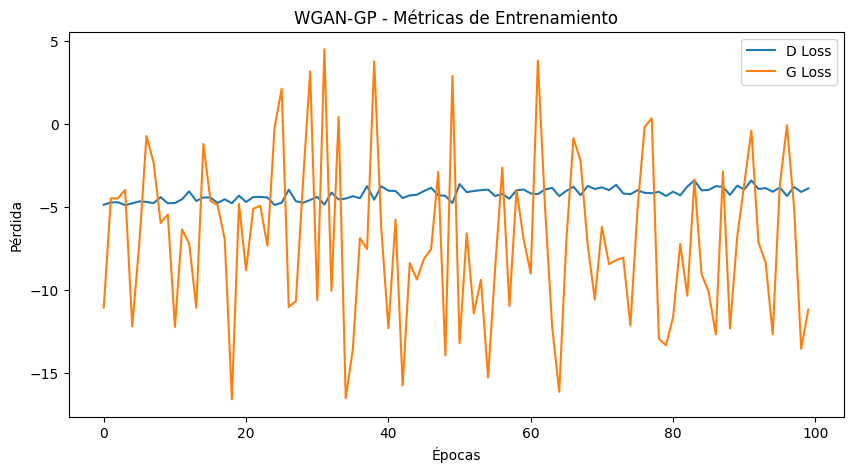

Entrenamiento completado.


In [30]:
# Listas para almacenar las métricas
d_losses = []
g_losses = []

# Ciclo de entrenamiento
epochs = 100
for epoch in range(epochs):
    d_loss_avg, g_loss = 0, 0
    for real_images in dataset:
        d_loss, g_loss = train_step(real_images)

    # Guardar las métricas de cada época
    d_losses.append(d_loss.numpy())
    g_losses.append(g_loss.numpy())

    print(f"Epoch {epoch + 1}/{epochs} - D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        generate_and_save_images(generator, epoch + 1)

    if (epoch + 1) % 10 == 0:
        save_models(generator, critic, epoch + 1)

# Visualizar las métricas
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), d_losses, label="D Loss")
plt.plot(range(epochs), g_losses, label="G Loss")
plt.title("WGAN-GP - Métricas de Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

print("Entrenamiento completado.")


Las metricas de entrenamiento sugieren lo siguiente:
- La pérdida del discriminador (línea azul) es notablemente más estable y se mantiene alrededor de -4 a -3. Esta estabilidad es característica de las WGAN y sugiere que el discriminador está aprendiendo de manera consistente.
- La pérdida del generador (línea naranja) muestra grandes oscilaciones, variando aproximadamente entre -15 y +5. Estas fluctuaciones son típicas en el entrenamiento de GANs y sugieren que el generador está teniendo dificultades para engañar consistentemente al discriminador.
-  Conclusión:
* El patrón es típico de una WGAN-GP en entrenamiento
* La estabilidad del discriminador es una buena señal, ya que es una de las mejoras que la WGAN introduce sobre las GANs tradicionales.
* Las oscilaciones del generador sugieren que podría beneficiarse de más ajuste en los hiperparámetros o más tiempo de entrenamiento


In [31]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# Parámetros
latent_dim = 100

# Rutas a los modelos guardados
generator_path = "/content/models/generator_epoch_30.h5"
critic_path = "/content/models/critic_epoch_30.h5"

# Cargar los modelos
generator = keras.models.load_model(generator_path)
critic = keras.models.load_model(critic_path)

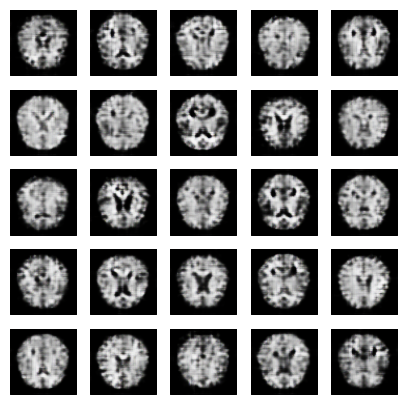

In [33]:
# Número de imágenes a generar
num_examples = 25

# Generar ruido aleatorio
noise = tf.random.normal([num_examples, latent_dim])

# Generar imágenes
generated_images = generator(noise, training=False)

# Mostrar las imágenes
plt.figure(figsize=(5, 5))
for i in range(num_examples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_images[i].numpy())
    plt.axis('off')
plt.show()

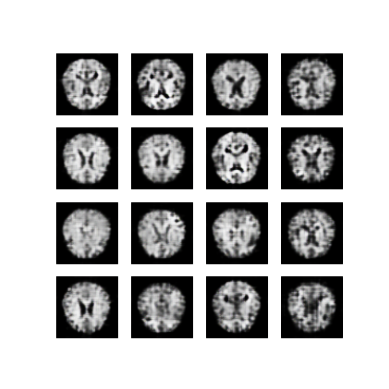

In [34]:
# Mostrar una imagen guardada (ejemplo: la última imagen generada)
img = plt.imread("generated_image_epoch_30.png")  # Reemplaza con la ruta correcta
plt.imshow(img)
plt.axis('off')
plt.show()

In [35]:
num_images_to_save = 50  # Número de imágenes que quieres guardar

# Cargar el generador (asegúrate de que la ruta sea correcta)
generator_path = "/content/models/generator_epoch_30.h5"
generator = keras.models.load_model(generator_path)

# Generar las imágenes
noise = tf.random.normal([num_images_to_save, latent_dim])
generated_images = generator(noise, training=False)

In [36]:
# Ruta al directorio en tu Google Drive donde quieres guardar las imágenes
drive_path = "/content/drive/MyDrive/Dataframes/WGAN_Alzheimer_Images"  # Reemplaza con tu ruta

# Crear el directorio si no existe
os.makedirs(drive_path, exist_ok=True)

# Guardar las imágenes en Google Drive
for i, img in enumerate(generated_images):
    img_path = os.path.join(drive_path, f"generated_image_{i}.png")
    plt.imsave(img_path, img.numpy())

print(f"Imágenes guardadas en: {drive_path}")

Imágenes guardadas en: /content/drive/MyDrive/Dataframes/WGAN_Alzheimer_Images


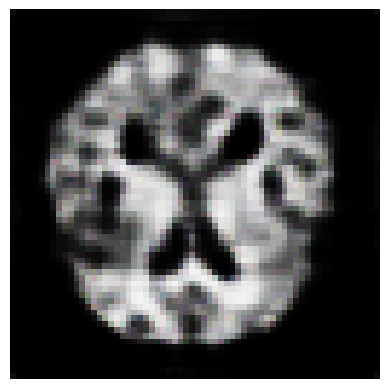

In [37]:
# Mostrar una imagen guardada (ejemplo: la primera imagen)
img_path = os.path.join(drive_path, "generated_image_10.png")
img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()